### Wizualizacja danych

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
my_blue="#0064B2"
my_red="#D61600"

In [3]:
df0 = pd.read_excel("dane_surowe_gaz.xlsx", sheet_name="Arkusz1")

In [4]:
df0.groupby('PACJENT_NR')['BADANIE_NR'].max().reset_index().max()

PACJENT_NR    145
BADANIE_NR     64
dtype: int64

In [5]:
df0=df0.pivot_table(index=("PACJENT_NR", "BADANIE_NR", "ZGON"), columns=["KOD_BADANIA"], values=["WYNIK"]) #ustawienie wyników w kolumnach
df0.reset_index(inplace=True) #rozpakowanie indeksów
df0.columns.name="Lp"
df0.columns=['PACJENT_NR','BADANIE_NR', 'ZGON', 'BETET', 'CO2TET', 'HCO3ACTE', 'HCO3STTE', 'O2SATTET', 'O2TET', 'PHTET']
#zamiana PH na liczbę jonów wodoru, min:35 , max: 45 (im więcej, tym niższe PH)
df0["IONH"]=10**(9-df0["PHTET"])

In [6]:
df0.head()

,PACJENT_NR,BADANIE_NR,ZGON,BETET,CO2TET,HCO3ACTE,HCO3STTE,O2SATTET,O2TET,PHTET,IONH
0,1,1,NIE,-0.8,57.1,26.1,21.9,82.6,57.0,7.269,53.826978
1,1,2,NIE,-1.9,87.2,26.2,21.8,99.3,197.0,NaN,NaN
2,1,3,NIE,1.2,66.0,28.5,24.2,99.6,225.0,7.244,57.016427
3,1,4,NIE,1.7,62.5,28.6,23.7,98.1,111.0,7.269,53.826978
4,1,5,NIE,0.5,61.1,27.5,23.9,99.1,145.0,7.262,54.701596


In [7]:
max_badanie_nr = df0.groupby('PACJENT_NR')['BADANIE_NR'].max().reset_index()
fig=px.bar(max_badanie_nr, x='BADANIE_NR', y="PACJENT_NR", orientation='h')
# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title='Liczba wykonanych badań',
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='Numer pacjenta',
        tickfont=dict(size=16),
        title_font=dict(size=20)
    )
)
fig.update_layout(template="plotly_white")

# Wyświetlamy wykres
fig.show()
fig.write_image("images1/liczba_pomiarow.png", width=1000, height=600, scale=4, format="png")

### Filtrowanie pacjentów >6 pomiarów

In [8]:
id_df=df0[["PACJENT_NR","BADANIE_NR"]].groupby('PACJENT_NR').max().add_suffix('_liczba')>6
id6=id_df.index[id_df["BADANIE_NR_liczba"]]
df_filtr=df0[df0['PACJENT_NR'].isin(id6)]

In [9]:
df_filtr[df_filtr.isna().any(axis=1)]

,PACJENT_NR,BADANIE_NR,ZGON,BETET,CO2TET,HCO3ACTE,HCO3STTE,O2SATTET,O2TET,PHTET,IONH
1,1,2,NIE,-1.9,87.2,26.2,21.8,99.3,197.0,NaN,NaN
36,1,37,NIE,NaN,NaN,NaN,NaN,84.0,76.2,NaN,NaN
49,1,50,NIE,6.7,54.9,31.9,29.6,NaN,102.0,7.373,42.364297
96,3,37,NIE,7.5,44.5,31.3,29.8,NaN,105.4,7.465,34.276779
1024,50,14,NIE,6.6,41.8,30.7,29.8,100.0,NaN,7.484,32.809529
2677,120,12,TAK,4.2,43.6,28.6,27.3,NaN,99.6,7.410,38.904514
2876,133,4,NIE,6.7,38.1,29.8,30.2,NaN,212.0,7.502,31.477483
2914,134,15,TAK,NaN,NaN,NaN,NaN,93.1,91.8,6.956,110.662378
2916,134,17,TAK,NaN,NaN,NaN,NaN,98.3,133.0,7.022,95.060479


### Korelacja

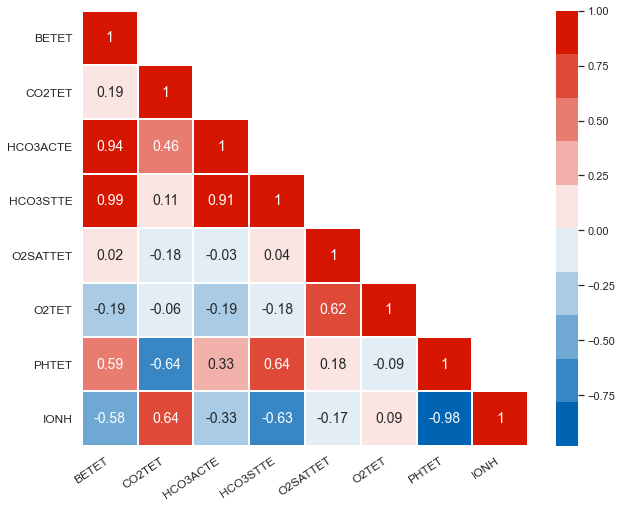

In [24]:
cmap = sns.blend_palette([my_blue, "white", my_red], n_colors=10)

# Parametry i korelacja
params = ['BETET','CO2TET','HCO3ACTE','HCO3STTE','O2SATTET','O2TET','PHTET','IONH']
df_corr = df_filtr[params].corr(method='pearson')
df_corr_rounded = df_corr.round(2)
mask = ~np.tril(np.ones(df_corr.shape[1])).astype(bool)

# Tworzenie wykresu
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')  # Ustawienie białego tła dla figury
ax.set_facecolor('white')  # Ustawienie białego tła dla osi

# Heatmapa
sns.heatmap(df_corr_rounded, cmap=cmap, annot=True, mask=mask, linewidths=0.1, annot_kws=dict(size=14), ax=ax)

# Etykiety osi
ax.set_xticklabels(params, rotation=34, ha='right', fontsize=12)
ax.set_yticklabels(params, fontsize=12)

plt.savefig("images1/korelacje.png", bbox_inches='tight')
# Wyświetlanie wykresu
plt.show()
# 

### Wykresy skrzypcowe

In [15]:
df_pom=df_filtr.copy()
df_pom["BETET"] = (df_pom["BETET"] - (-2.3))/(2.3 - -(2.3))
df_pom["IONH"] = (df_pom["IONH"] - 35)/(45 - 35)
df_pom["O2SATTET"] = (df_pom["O2SATTET"] - 95)/(100 - 95)
df_pom["CO2TET"] = (df_pom["CO2TET"] - 35)/(45 - 35)
df_pom["O2TET"] = (df_pom["O2TET"] - 75)/(100 - 75)
df_pom["HCO3STTE"] = (df_pom["HCO3STTE"] - 21)/(25 - 21)
df_pom["HCO3ACTE"] = (df_pom["HCO3ACTE"] - 21)/(27 - 21)
df_pom["PHTET"] = (df_pom["PHTET"] - 7.35)/(7.45 - 7.35)
df_pom["ZGON"] = np.where(df_pom["ZGON"] == "NIE", 0, 1)

df_filtr_std=df_pom
df_filtr_std.to_csv("filtered_std_data_gasometry.csv")

In [16]:
fig = go.Figure()
cols=["BETET",	"CO2TET","HCO3ACTE","HCO3STTE",	"O2SATTET",	"O2TET", "IONH"]

for col in df_filtr_std[cols]:  # Iteracja po wszystkich kolumnach oprócz ZGON
    for zgon in df_filtr_std['ZGON'].unique():
        subset = df_filtr_std[df_filtr_std['ZGON'] == zgon]
        side = "negative" if zgon == 0 else "positive"
        color = my_blue if zgon == 0 else my_red

        fig.add_trace(go.Violin(y=subset[col], box_visible=True, name=f"{col}",
                                side=side, line_color=color, box={'visible': True}, opacity=0.8))

# Dodanie poziomej linii w y=0 i y=1
fig.update_layout(shapes=[go.layout.Shape(type='line', x0=0, x1=1, xref='paper', y0=0, y1=0, line=dict(color='black', dash='dot', width=1.5)),
                          go.layout.Shape(type='line', x0=0, x1=1, xref='paper', y0=1, y1=1, line=dict(color='black', dash='dot', width=1.5))])

# Dostosowanie rozmiaru czcionki osi x i y
fig.update_layout(xaxis=dict(tickfont=dict(size=14)), yaxis=dict(tickfont=dict(size=14)))
fig.update_layout(showlegend=False)
fig.update_layout(height=600, width=1000)
fig.update_layout(template="plotly_white")
fig.show()
fig.write_image("images1/rozklad_parametrow.png", format="png", scale=3)